# PART A: DOCUMENT CLUSTERING
We will solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation maximization for document clustering)

## Question 1: EM for Document Clustering
### Part I: Derive Expectation and Maximization steps of the hard-EM algorithm for document clustering.
Report included

### Part II: Implement hard-EM and soft-EM
The following part of code are taken from provided codebase and part of Activity 4.1 to facilitate the process of this assignment.

In [1]:
# install.packages("tm", repos='http://cran.us.r-project.org')
library(SnowballC)
library(tm)
library(ggplot2)

Loading required package: NLP

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



In [2]:
# Written by Gholamreza Haffari and Borhan Kazimipour, July 2016
#======
#You are welcome to use this code for your submission if you would like to; otherwise, you are welcome to use your own code that you have developed so far. 

# The main aim is to help you folks to move forward to interesting parts of the Assessment, and to not get stuck in some implementation details.
# Carefully note the comments throughout the code, particularly theory relating to handle small numbers in the log space and how to prevent NaN 
# when normalising a non-negative vector to get probability distribution. 
#========

eps=1e-10
  
# reading the data
read.data <- function(file.name, sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
    
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame('doc_id'=seq(1:length(text)), 'text'=unlist(lapply(docs, function(x) x[2])))
  
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

#### Implement E step of soft/hard EM algorithm

In [3]:
##--- E Step for Document Clustering  --------------------------------------------
# this function is based on the codebase to implement E step for Document Clustering
# the parameter hard.em is added to implement E step of hard EM 
E.step <- function(gamma, model, counts, hard.em=TRUE){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    # E step:    
    for (n in 1:N){
        for (k in 1:K){
            ## calculate the posterior based on the estimated mu and rho in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
    }
  
    # converting back from the log space 
    gamma <- exp(gamma)
    
    # if implementing hard EM, we will make hard assignment for each data point
    # which means assigning it to the cluster with the highest probability by 1, otherwise assigning 0 to this data point 
    if (hard.em){
        max.prob <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
        gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
        gamma[!max.prob] <- 0 # remove points from clusters with lower probabilites
    }
    
    return (gamma)
}

#### Implement M step of soft/hard EM algorithm

In [4]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts, hard.em = TRUE){
    # the input model includes parameters such as rho and mu
    # Model Parameter Setting
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters

    # M step
    # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
    # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
    # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], 
    # then divide the elements by (n1+n2+n3+ 3*eps) so that the vector sums to 1. 
    # this prevents NaN for vectors where all elements are zero such as [0,0,0] 
    # because after adding eps you have [eps,eps,eps] which results in the uniform distribution after normalisation. 
  
    for (k in 1:K){
        # recalculate the mixing components
        model$rho[k,1] <- sum(gamma[, k])/N
        
        # recalculate the mu
        for (w in 1:W){
            model$mu[k, w] <- sum(gamma[,k]*counts[w,])/sum(gamma[,k] * counts)
        }
        
        # Normalize mu
        model$mu[k,] <- (model$mu[k,] + eps)/sum(model$mu[k,] + W*eps)
    }
    
    # Return the result
    return (model)
}

#### Implement EM for Document Clustering

In [5]:
EM <- function(counts, K=4, max.epoch=10, hard.em= TRUE, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step(gamma, model, counts, hard.em=TRUE)
    # M Step
    model <- M.step(gamma, model, counts, hard.em=TRUE)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

### Part III: Load Task2A.text file and necessary libraries, set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data

In [6]:
# loading documents 
## Note: sample.size=0 means all read all documents!
##(for development and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./assignment2_datasets/Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat   
counts

,1,2,3,4,5,6,7,8,9,10,...,2364,2365,2366,2367,2368,2369,2370,2371,2372,2373
abl,2,2,0,0,0,0,0,1,0,0,...,0,0,4,0,0,0,0,0,0,0
accept,1,2,1,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,0,0,0
access,2,2,4,1,0,0,0,0,0,0,...,2,5,0,0,0,0,0,0,0,0
accur,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
actual,1,1,0,0,1,3,0,0,0,0,...,0,0,5,0,0,0,1,0,0,0
addit,2,3,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
advic,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agenc,2,2,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
algorithm,2,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
allow,7,6,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Perform hard EM and soft EM

In [7]:
# implement hard EM algorithm on the data
hard.em.df <- EM(counts, K=4, max.epoch=5, hard.em=TRUE)
hard.em.df

[1] 2168181
[1] 1951317
[1] 1934651
[1] 1925992
[1] 1920392
[1] 1917898


$model
$model$rho
          [,1]
[1,] 0.3426043
[2,] 0.1209440
[3,] 0.2815002
[4,] 0.2549515

$model$mu
             [,1]         [,2]         [,3]         [,4]         [,5]
[1,] 0.0009711551 0.0005648555 0.0016251982 0.0001090073 0.0012387182
[2,] 0.0006672742 0.0006066129 0.0019866572 0.0002729758 0.0006217782
[3,] 0.0010067167 0.0002423578 0.0016032895 0.0001305004 0.0022371481
[4,] 0.0008167661 0.0008501035 0.0004667236 0.0003167053 0.0015168513
             [,6]         [,7]         [,8]         [,9]        [,10]
[1,] 0.0007630504 0.0002576535 0.0020909562 2.814368e-03 0.0008423284
[2,] 0.0010919032 0.0002274799 0.0010312419 1.152565e-03 0.0014558709
[3,] 0.0005592871 0.0002237149 0.0001864291 5.592885e-05 0.0005592871
[4,] 0.0004667236 0.0006167418 0.0003167053 3.333751e-05 0.0004833922
            [,11]       [,12]        [,13]        [,14]        [,15]
[1,] 0.0009612453 0.003171118 1.387365e-04 0.0002873827 2.378340e-04
[2,] 0.0005004557 0.004625423 8.492581e-04 0.0002729758 6.475592e-03
[3,] 0.0006338587 0.003840437 7.457175e-05 0.0011185741 1.864305e-05
[4,] 0.0005500670 0.003767125 4.167175e-04 0.0008501035 1.666881e-05
            [,16]        [,17]       [,18]        [,19]        [,20]
[1,] 0.0010405233 0.0008225089 0.001972039 0.0010207038 0.0007234115
[2,] 0.0009705806 0.0015468629 0.001152565 0.0004246291 0.0015013669
[3,] 0.0006897874 0.0007084303 0.003206579 0.0017710756 0.0004287868
[4,] 0.0016335321 0.0007334227 0.002516973 0.0012001461 0.0002500305
            [,21]        [,22]        [,23]        [,24]        [,25]
[1,] 6.639530e-04 4.162094e-04 0.0006144043 0.0009216064 0.0012882669
[2,] 1.364879e-04 1.925996e-03 0.0010009113 0.0006672742 0.0013042177
[3,] 3.728595e-05 3.728595e-05 0.0013982176 0.0018642901 0.0008948593
[4,] 2.333618e-04 3.333751e-05 0.0008334348 0.0013501643 0.0012001461
            [,26]        [,27]        [,28]        [,29]        [,30]
[1,] 6.243140e-04 0.0002972924 1.387365e-04 0.0013477254 0.0019026711
[2,] 1.395210e-03 0.0005307863 5.459516e-04 0.0011222339 0.0043676127
[3,] 7.457175e-05 0.0004474297 1.492383e-10 0.0001491433 0.0008762164
[4,] 6.500792e-04 0.0003167053 6.667490e-05 0.0004500549 0.0007167540
            [,31]        [,32]        [,33]        [,34]        [,35]
[1,] 0.0002378340 0.0007828699 1.288268e-04 0.0004954873 7.927805e-05
[2,] 0.0002729758 0.0003639678 2.881412e-04 0.0003639678 4.549602e-05
[3,] 0.0007643590 0.0005965729 9.321465e-05 0.0002982865 5.592885e-05
[4,] 0.0005167296 0.0011168026 2.666992e-04 0.0004833922 2.333618e-04
            [,36]        [,37]        [,38]        [,39]        [,40]
[1,] 0.0010702525 5.945856e-05 0.0001882852 0.0005549458 0.0049053238
[2,] 0.0006824395 1.668186e-04 0.0007734315 0.0006066129 0.0007885968
[3,] 0.0009694309 7.457175e-05 0.0004101439 0.0005592871 0.0010626454
[4,] 0.0018168878 1.000123e-04 0.0004000488 0.0015168513 0.0006834166
            [,41]        [,42]       [,43]        [,44]       [,45]
[1,] 1.387365e-04 2.576535e-04 0.002576534 0.0001585560 0.011554763
[2,] 1.516533e-04 1.364879e-04 0.001895665 0.0001516533 0.007279354
[3,] 1.492383e-10 7.457175e-05 0.001733790 0.0005779300 0.009694308
[4,] 1.166810e-04 3.000366e-04 0.002316949 0.0004167175 0.009817861
            [,46]        [,47]        [,48]        [,49]        [,50]
[1,] 0.0002675632 0.0004855776 0.0001090073 9.909754e-05 2.279242e-04
[2,] 0.0006217782 0.0007127702 0.0002729758 2.578105e-04 3.639678e-04
[3,] 0.0002610007 0.0005965729 0.0001305004 1.491433e-04 9.321465e-05
[4,] 0.0002833679 0.0004500549 0.0002000244 3.333740e-04 1.198646e-10
            [,51]        [,52]        [,53]        [,54]        [,55]
[1,] 1.585560e-04 0.0006342238 1.080162e-03 7.828699e-04 0.0005351263
[2,] 1.819839e-04 0.0003942984 6.369436e-04 3.033065e-04 0.0003184718
[3,] 9.321465e-05 0.0009507880 1.492383e-10 9.321465e-05 0.0004660726
[4,] 1.000123e-04 0.0005333983 1.198646e-10 2.500305e-04 0.0010501278
            [,56]        [,57]        [,58]        [,59]       [,6

In [8]:
# implement soft EM algorithm on the data
soft.em.df <- EM(counts, K=4, max.epoch=5, hard.em=FALSE)
soft.em.df

[1] 2173820
[1] 1948810
[1] 1932547
[1] 1924095
[1] 1919409
[1] 1917212


$model
$model$rho
          [,1]
[1,] 0.2768647
[2,] 0.2583228
[3,] 0.3383902
[4,] 0.1264223

$model$mu
             [,1]         [,2]        [,3]         [,4]        [,5]
[1,] 0.0010121328 0.0007534766 0.002001774 0.0001124593 0.001034625
[2,] 0.0006405451 0.0005152211 0.001434264 0.0001949486 0.001155766
[3,] 0.0009437168 0.0005410643 0.001396701 0.0002768237 0.001686107
[4,] 0.0008441939 0.0003476093 0.000422097 0.0002234631 0.001688388
             [,6]         [,7]         [,8]         [,9]        [,10]
[1,] 0.0007872144 0.0002024266 0.0017656093 0.0032050869 0.0014169858
[2,] 0.0008633434 0.0005012962 0.0013089399 0.0007937189 0.0005430709
[3,] 0.0003523210 0.0001761606 0.0003397381 0.0001635777 0.0005284814
[4,] 0.0011669738 0.0005462431 0.0007448769 0.0002482924 0.0008193646
            [,11]       [,12]        [,13]        [,14]        [,15]
[1,] 0.0008097062 0.003542464 0.0006972470 0.0003373776 4.723286e-03
[2,] 0.0008494185 0.003606547 0.0003341975 0.0007797940 1.253241e-04
[3,] 0.0005410643 0.003749701 0.0001006632 0.0007046419 2.768237e-04
[4,] 0.0005214139 0.004593407 0.0001241462 0.0003972677 4.965854e-05
           [,16]        [,17]       [,18]        [,19]        [,20]
[1,] 0.001057116 0.0013157726 0.002136725 0.0009221654 0.0008659358
[2,] 0.001113991 0.0006823198 0.001963410 0.0012393154 0.0002924228
[3,] 0.001019214 0.0008808023 0.002466246 0.0012205403 0.0005662301
[4,] 0.001216632 0.0007697062 0.001762875 0.0007448769 0.0016635584
            [,21]        [,22]        [,23]        [,24]        [,25]
[1,] 5.735419e-04 0.0012258052 0.0007084930 0.0006185256 0.0015744287
[2,] 2.506481e-04 0.0001670988 0.0008772683 0.0008076438 0.0013089399
[3,] 6.291457e-05 0.0004907328 0.0011827917 0.0018874334 0.0009185510
[4,] 4.469262e-04 0.0003227801 0.0008193646 0.0013656077 0.0007200477
            [,26]        [,27]        [,28]        [,29]       [,30]
[1,] 0.0015856746 5.060664e-04 5.735419e-04 0.0012595430 0.003553710
[2,] 0.0005430709 2.367233e-04 4.177478e-05 0.0013089399 0.001392489
[3,] 0.0001132461 5.410643e-04 1.220125e-10 0.0003397381 0.001409284
[4,] 0.0002234631 7.448777e-05 8.768442e-11 0.0002979508 0.001042828
            [,31]        [,32]        [,33]        [,34]        [,35]
[1,] 0.0003148858 0.0006072797 1.911807e-04 0.0004610828 3.373784e-05
[2,] 0.0005848455 0.0009190429 3.202726e-04 0.0005152211 2.227984e-04
[3,] 0.0003649039 0.0007046419 8.808034e-05 0.0003523210 1.006632e-04
[4,] 0.0003724385 0.0006455600 1.489755e-04 0.0003227801 2.482932e-05
            [,36]        [,37]        [,38]        [,39]        [,40]
[1,] 0.0009783950 1.012134e-04 6.860011e-04 0.0007084930 0.0049032206
[2,] 0.0018659356 5.569967e-05 4.873713e-04 0.0010304421 0.0006962447
[3,] 0.0009185510 1.635777e-04 2.139092e-04 0.0007298077 0.0016106099
[4,] 0.0004965847 2.482932e-05 7.448777e-05 0.0005462431 0.0007697062
            [,41]        [,42]       [,43]        [,44]       [,45]
[1,] 1.012134e-04 0.0002361644 0.002642791 0.0001574429 0.011245919
[2,] 2.227984e-04 0.0002367233 0.002562180 0.0003202726 0.009817049
[3,] 7.549745e-05 0.0001761606 0.001837102 0.0004026526 0.008858354
[4,] 8.768442e-11 0.0001241462 0.001291120 0.0003227801 0.008590913
            [,46]        [,47]        [,48]        [,49]        [,50]
[1,] 0.0003486236 0.0002699021 0.0001349511 0.0001012134 4.273450e-04
[2,] 0.0002088735 0.0005430709 0.0001810237 0.0002506481 1.392499e-05
[3,] 0.0002390750 0.0006291446 0.0001635777 0.0003019895 1.384119e-04
[4,] 0.0008441939 0.0010428277 0.0002482924 0.0000993170 4.965854e-05
            [,51]        [,52]        [,53]        [,54]        [,55]
[1,] 1.124593e-04 0.0006522634 1.619412e-03 4.498368e-04 0.0004498368
[2,] 9.747434e-05 0.0005430709 9.747434e-05 9.747425e-04 0.0007240945
[3,] 1.258290e-04 0.0005284814 1.220125e-10 7.549745e-05 0.0007046419
[4,] 2.979508e-04 0.0008441939 8.768442e-11 7.448777e-05 0.0003724385
            [,56]        [,57]        [,58]        [,59]       [,60]
[1,] 0.0001237052

### Part IV: Perform a PCA on the clusters obtained from the hard EM and soft EM. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components

In [9]:
## normalize the count matrix for better visualization
scl.counts <- scale(counts) # only use when the dimensionality of the data (number of words) is large enough

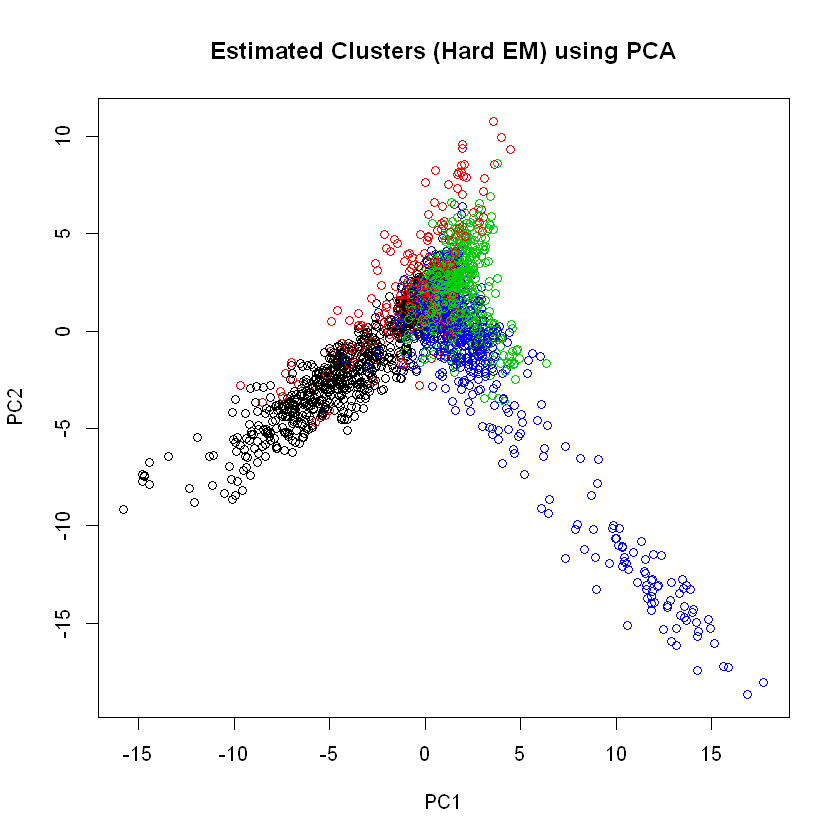

In [10]:
# visualization of PCA on hard EM clusterings
## visualize the estimated clusters
hard.label <- apply(hard.em.df$gamma, 1, which.max)
cluster.viz(t(scl.counts), hard.label, 'Estimated Clusters (Hard EM) using PCA')

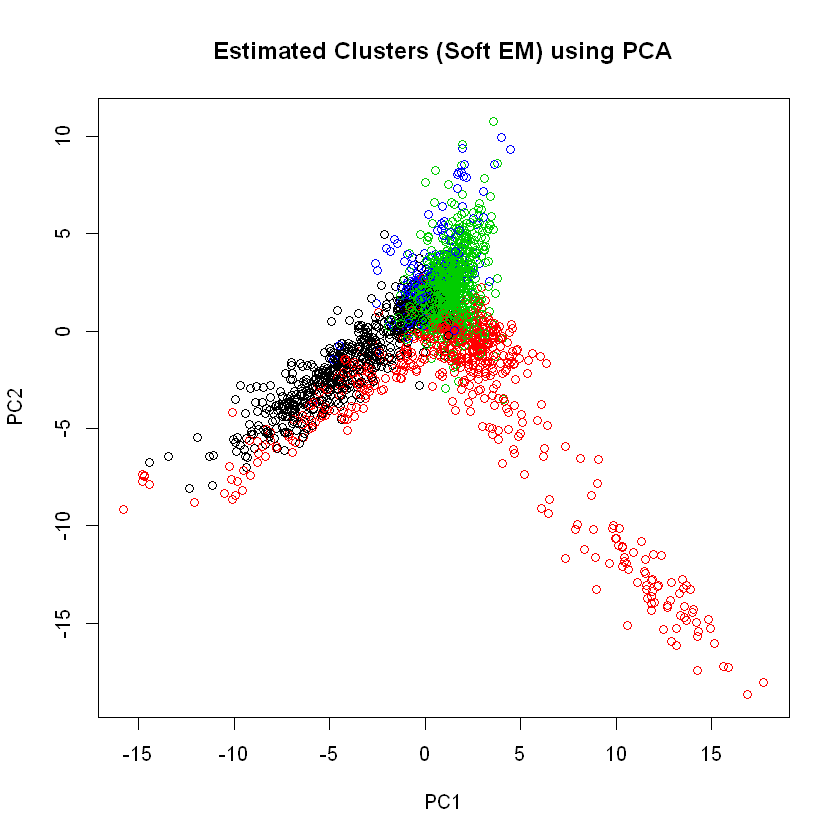

In [11]:
# visualization of PCA on the soft EM clusterings
## find the cluster with the maximum probability (since we have soft assignment here)
soft.label <- apply(soft.em.df$gamma, 1, which.max)

## visualize the estimated clusters
cluster.viz(t(scl.counts), soft.label, 'Estimated Clusters (Soft EM) using PCA')

From the two plots above, we can not really see which algorithm performs better in clustering the documents. So we need a better way to visualize these clusters.